# Metodología integral para la limpieza y exploración de datos de telemetría en cuadricópteros: detección de valores faltantes y atípicos

En esta sección se describe el enfoque seguido para extraer, procesar y modelar los datos de vuelo, con el fin de identificar relaciones no lineales entre variables dinámicas del cuadricóptero mediante técnicas de aprendizaje automático y profundo.

## Dataset
- **Fuente**: registros “Blackbox” generados por Betaflight en un cuadricóptero.  
- **Variables de interés**:  
  - Aceleraciones lineales en ejes X, Y, Z.  
  - Velocidades angulares (giroscopio) en roll, pitch, yaw.  
  - Señales PWM de los cuatro motores.  
  - Comandos RC (throttle, roll, pitch, yaw).  
  - Parámetros de actitud (ángulos de Euler).  
- **Preparación y limpieza**: filtrado de registros corruptos, unificación de formatos de tiempo, normalización y eliminación de duplicados.

### Cargar Dataset

In [1]:
import pandas as pd


def load_blackbox_log(file_path: str) -> pd.DataFrame:
    """
    Carga un archivo CSV de registro Betaflight Blackbox en un DataFrame.

    Parámetros:
    -----------
    file_path : str
        Ruta al archivo CSV del log.

    Retorna:
    --------
    pd.DataFrame
        DataFrame con las columnas y registros del log cargado.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}") from e
    return df


# Implementación
file_path = "DATOS_DRON.csv"  # Ajusta la ruta según corresponda
data = load_blackbox_log(file_path)

print("Dimensiones del dataset:", data.shape)
display(data.head())
print("Estadísticas generales del dataset:")
data.info()

Dimensiones del dataset: (308443, 51)


,loopIteration,time,rollPID[0],rollPID[1],rollPID[2],pitchPID[0],pitchPID[1],pitchPID[2],yawPID[0],yawPID[1],...,rcCommands[1],rcCommands[2],rcCommands[3],axisError[0],axisError[1],axisError[2],motorLegacy[0],motorLegacy[1],motorLegacy[2],motorLegacy[3]
0,0,192615357,40,40,30,58,50,35,70,45,...,1,1,0.0,0,1,1,96,73,89,85
1,8,192616873,40,40,30,58,50,35,70,45,...,1,1,0.0,0,1,1,94,73,88,85
2,16,192617887,40,40,30,58,50,35,70,45,...,1,1,0.0,0,1,1,94,73,87,86
3,24,192618909,40,40,30,58,50,35,70,45,...,1,1,0.0,0,1,1,89,73,80,84
4,32,192619922,40,40,30,58,50,35,70,45,...,1,1,0.0,0,1,1,93,73,84,84


Estadísticas generales del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308443 entries, 0 to 308442
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   loopIteration   308443 non-null  int64  
 1   time            308443 non-null  int64  
 2   rollPID[0]      308443 non-null  int64  
 3   rollPID[1]      308443 non-null  int64  
 4   rollPID[2]      308443 non-null  int64  
 5   pitchPID[0]     308443 non-null  int64  
 6   pitchPID[1]     308443 non-null  int64  
 7   pitchPID[2]     308443 non-null  int64  
 8   yawPID[0]       308443 non-null  int64  
 9   yawPID[1]       308443 non-null  int64  
 10  yawPID[2]       308443 non-null  int64  
 11  axisP[0]        308443 non-null  int64  
 12  axisP[1]        308443 non-null  int64  
 13  axisP[2]        308443 non-null  int64  
 14  axisI[0]        308443 non-null  int64  
 15  axisI[1]        308443 non-null  int64  
 16  axisI[2]        3084

### Listado de variables

In [2]:
import re


def automatic_categorize_dict(df: pd.DataFrame) -> dict:
    """
    Categoriza automáticamente las variables extrayendo el prefijo de cada nombre de columna.
    - Prefijos con más de una variable crean una categoría propia.
    - Prefijos únicos se agrupan en 'others'.
    Retorna un diccionario {categoría: [variables]}.
    """
    # Extraer prefijo (letras iniciales) o el nombre completo si no hay prefijo
    prefix_map = {
        col: (
            re.match(r"^([A-Za-z]+)", col).group(1)
            if re.match(r"^([A-Za-z]+)", col)
            else col
        )
        for col in df.columns
    }

    # Agrupar por prefijo
    from collections import defaultdict

    groups = defaultdict(list)
    for col, pref in prefix_map.items():
        groups[pref].append(col)

    # Construir categorías
    categories = {}
    for pref, cols in groups.items():
        if len(cols) > 1:
            categories[pref] = cols
        else:
            categories.setdefault("others", []).extend(cols)

    return categories


# Ejecutar categorización y mostrar resultados
categories = automatic_categorize_dict(data)
for category, variables in categories.items():
    print(f"{category} ({len(variables)} variables):")
    for var in variables:
        print(f"  - {var}")
    print()

others (2 variables):
  - loopIteration
  - time

rollPID (3 variables):
  - rollPID[0]
  - rollPID[1]
  - rollPID[2]

pitchPID (3 variables):
  - pitchPID[0]
  - pitchPID[1]
  - pitchPID[2]

yawPID (3 variables):
  - yawPID[0]
  - yawPID[1]
  - yawPID[2]

axisP (3 variables):
  - axisP[0]
  - axisP[1]
  - axisP[2]

axisI (3 variables):
  - axisI[0]
  - axisI[1]
  - axisI[2]

axisD (3 variables):
  - axisD[0]
  - axisD[1]
  - axisD[2]

rcCommand (4 variables):
  - rcCommand[0]
  - rcCommand[1]
  - rcCommand[2]
  - rcCommand[3]

gyroADC (3 variables):
  - gyroADC[0]
  - gyroADC[1]
  - gyroADC[2]

accSmooth (3 variables):
  - accSmooth[0]
  - accSmooth[1]
  - accSmooth[2]

motor (4 variables):
  - motor[0]
  - motor[1]
  - motor[2]
  - motor[3]

heading (3 variables):
  - heading[0]
  - heading[1]
  - heading[2]

axisSum (3 variables):
  - axisSum[0]
  - axisSum[1]
  - axisSum[2]

rcCommands (4 variables):
  - rcCommands[0]
  - rcCommands[1]
  - rcCommands[2]
  - rcCommands[3]

axisError

### Descategorizar 

In [3]:
def filter_variables_by_categories(
    categories_dict: dict, selected_categories: list
) -> list:
    """
    Retorna una lista de variables que pertenecen a las categorías indicadas.

    Parámetros:
    -----------
    categories_dict : dict
        Diccionario donde cada llave es una categoría y su valor es la lista de variables.
    selected_categories : list
        Lista de categorías que se quieren extraer.

    Retorna:
    --------
    list: Variables de las categorías seleccionadas.
    """
    return [
        var
        for cat, vars_list in categories_dict.items()
        if cat in selected_categories
        for var in vars_list
    ]


# Ejemplo de uso:
# Asumiendo que 'categories' es tu diccionario de categorías
# y quieres extraer variables de las categorías 'axisP' y 'rcCommands'
variables_seleccionadas = filter_variables_by_categories(
    categories, ["gyroADC", "motor"]
)

# Imprimir resultado
print("Variables seleccionadas:", variables_seleccionadas)

Variables seleccionadas: ['gyroADC[0]', 'gyroADC[1]', 'gyroADC[2]', 'motor[0]', 'motor[1]', 'motor[2]', 'motor[3]']


### Limpiar faltantes

In [4]:
from scipy import stats

# --- Supuesto: 'data' ya está cargado como DataFrame ---


def clean_missing_values(df: pd.DataFrame, method: str = "interpolate") -> pd.DataFrame:
    """
    Imputa valores faltantes en el DataFrame según el método especificado.

    Parámetros:
    -----------
    df : pd.DataFrame
    method : str
        'interpolate' (lineal), 'ffill' (adelante), 'bfill' (atrás) o 'drop' (eliminar filas).

    Retorna:
    --------
    pd.DataFrame limpio sin NaN.
    """
    df_clean = df.copy()
    if method == "interpolate":
        df_clean = df_clean.interpolate().ffill().bfill()
    elif method == "ffill":
        df_clean = df_clean.ffill().bfill()
    elif method == "bfill":
        df_clean = df_clean.bfill().ffill()
    elif method == "drop":
        df_clean = df_clean.dropna()
    else:
        raise ValueError("method debe ser 'interpolate', 'ffill', 'bfill' o 'drop'")
    return df_clean


# Estadísticas antes de la limpieza
missing_before = data.isna().sum()

# Aplicar limpieza
data_clean_missing = clean_missing_values(data, method="interpolate")

# Estadísticas después de la limpieza
missing_after = data_clean_missing.isna().sum()

# Construir DataFrame de estadísticas
stats_df = pd.DataFrame(
    {"missing_before": missing_before, "missing_after": missing_after}
)
stats_df["removed"] = stats_df["missing_before"] - stats_df["missing_after"]
stats_df["percent_removed"] = (
    stats_df["removed"] / stats_df["missing_before"].replace({0: 1})
) * 100

# Mostrar resultados interactivos
print("Estadísticas de valores faltantes antes y después de la limpieza")
display(stats_df)

Estadísticas de valores faltantes antes y después de la limpieza


,missing_before,missing_after,removed,percent_removed
loopIteration,0,0,0,0.0
time,0,0,0,0.0
rollPID[0],0,0,0,0.0
rollPID[1],0,0,0,0.0
rollPID[2],0,0,0,0.0
pitchPID[0],0,0,0,0.0
pitchPID[1],0,0,0,0.0
pitchPID[2],0,0,0,0.0
yawPID[0],0,0,0,0.0
yawPID[1],0,0,0,0.0


### Histogramas

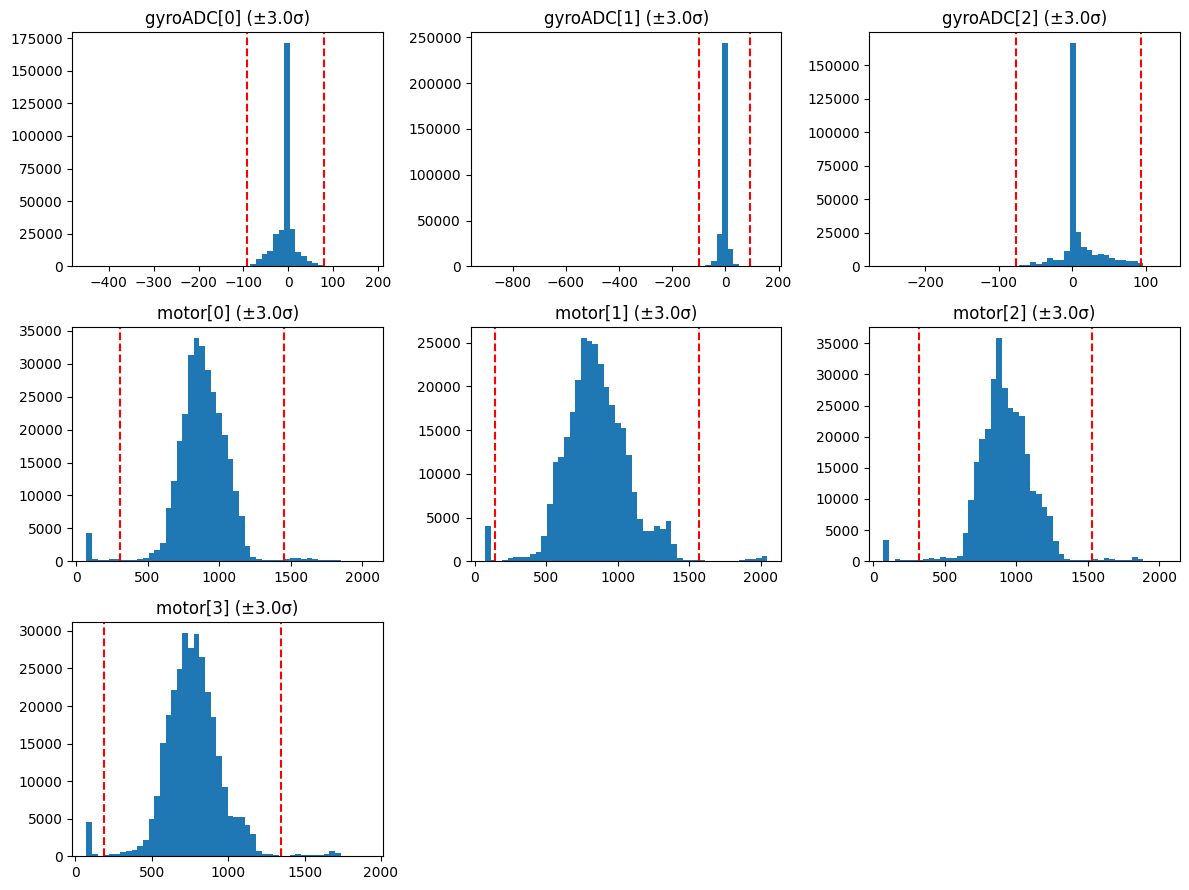

In [5]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_histograms_outlier_subplots(
    df: pd.DataFrame,
    columns=None,
    bins: int = 50,
    figsize_per_plot: tuple = (4, 3),
    save_path: str = None,
    min_outlier_fraction: float = 0.0,
    outlier_method: str = "zscore",
    z_thresh: float = 3.0,
    iqr_factor: float = 1.5,
    percentile_bounds: tuple = (1, 99),
):
    """
    Genera histogramas en subplots de columnas numéricas (o especificadas), marcando outliers
    según el método elegido, y opcionalmente guarda la figura en SVG.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con las variables.
    columns : list, opcional
        Columnas a graficar; si None, se usan todas las numéricas.
    bins : int
        Número de bins para el histograma.
    figsize_per_plot : tuple
        Tamaño de cada subplot (ancho, alto).
    save_path : str, opcional
        Ruta para guardar la figura en formato SVG.
    min_outlier_fraction : float
        Umbral mínimo de fracción de outliers para incluir la variable (0 = todas).
    outlier_method : str
        Método para detectar outliers: 'zscore', 'iqr' o 'percentile'.
    z_thresh : float
        Umbral de sigma para el método 'zscore'.
    iqr_factor : float
        Factor multiplicador del rango IQR para 'iqr'.
    percentile_bounds : tuple(int, int)
        Percentiles inferior y superior para 'percentile' (ej. (1, 99)).
    """
    cols = columns or df.select_dtypes(include=[np.number]).columns.tolist()
    selected = []

    # Filtrar variables según fracción de outliers
    for col in cols:
        data = df[col].dropna()
        if outlier_method == "zscore":
            mu, sigma = data.mean(), data.std()
            outliers = data[
                (data < mu - z_thresh * sigma) | (data > mu + z_thresh * sigma)
            ]
            title_suffix = f"±{z_thresh}σ"
        elif outlier_method == "iqr":
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - iqr_factor * IQR, Q3 + iqr_factor * IQR
            outliers = data[(data < lower) | (data > upper)]
            title_suffix = f"IQR×{iqr_factor}"
        elif outlier_method == "percentile":
            lower = np.percentile(data, percentile_bounds[0])
            upper = np.percentile(data, percentile_bounds[1])
            outliers = data[(data < lower) | (data > upper)]
            title_suffix = f"{percentile_bounds[0]}–{percentile_bounds[1]}pct"
        else:
            raise ValueError("outlier_method debe ser 'zscore', 'iqr' o 'percentile'")

        frac = len(outliers) / len(data) if len(data) > 0 else 0
        if frac >= min_outlier_fraction:
            selected.append((col, title_suffix))

    if not selected:
        print(
            f"No hay variables con fracción de outliers >= threshold usando {outlier_method}"
        )
        return

    n = len(selected)
    ncols = int(math.ceil(math.sqrt(n)))
    nrows = int(math.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)
    )
    axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

    for idx, (col, title_suffix) in enumerate(selected):
        ax = axes_flat[idx]
        series = df[col].dropna()
        ax.hist(series, bins=bins)
        ax.set_title(f"{col} ({title_suffix})")
        # Dibujar líneas de outlier según método
        if outlier_method == "zscore":
            mu, sigma = series.mean(), series.std()
            ax.axvline(mu - z_thresh * sigma, linestyle="--", color="red")
            ax.axvline(mu + z_thresh * sigma, linestyle="--", color="red")
        elif outlier_method == "iqr":
            Q1, Q3 = series.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            ax.axvline(Q1 - iqr_factor * IQR, linestyle="--", color="red")
            ax.axvline(Q3 + iqr_factor * IQR, linestyle="--", color="red")
        else:  # percentile
            low, high = np.percentile(series, percentile_bounds)
            ax.axvline(low, linestyle="--", color="red")
            ax.axvline(high, linestyle="--", color="red")

    # Eliminar ejes sobrantes
    for j in range(n, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, format="svg")
    plt.show()


# Ejemplo de uso:
plot_histograms_outlier_subplots(
    data_clean_missing,
    outlier_method="zscore",
    min_outlier_fraction=0,
    save_path="Imágenes/Histogramas de variables relevantes con zscore.svg",
    columns=variables_seleccionadas,
)

# plot_histograms_outlier_subplots(
#    data_clean_missing,
#    outlier_method="iqr",
#    min_outlier_fraction=0.05,
#    save_path="Imágenes/outliers_iqr.svg",
#    columns=variables_seleccionadas,
# )

# plot_histograms_outlier_subplots(
#    data_clean_missing,
#    outlier_method="percentile",
#    min_outlier_fraction=0.05,
#    save_path="Imágenes/outliers_percentile.svg",
#    columns=variables_seleccionadas,
# )

### Limpiar atípicos

In [6]:
from typing import Tuple

import numpy as np
import pandas as pd


# ----- FUNCIÓN NORMAL -----
def clean_outliers_extended(
    df: pd.DataFrame,
    clean_method: str = "interpolate",
    z_thresh: float = 3.0,
    percentile_bounds: Tuple[int, int] = (1, 99),
    stat: str = "median",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Detecta y limpia outliers usando varios métodos, y retorna estadísticas.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada.
    clean_method : str
        Método de limpieza:
        - 'drop'            : elimina filas con outliers (Z-score).
        - 'cap_percentile'  : capping en percentiles (percentile_bounds).
        - 'cap_sigma'       : capping en σ (z_thresh).
        - 'impute'          : reemplazo por estadístico (stat) en outliers Z-score.
        - 'interpolate'     : interpolación lineal en outliers Z-score.
    z_thresh : float
        Umbral de desviaciones estándar para métodos basados en Z-score.
    percentile_bounds : tuple(int, int)
        Percentiles inferior y superior para capping en percentiles.
    stat : str o numérico
        Para 'impute': 'median', 'mean' o valor numérico fijo.

    Retorna:
    --------
    df_clean : pd.DataFrame
        DataFrame tras limpieza.
    stats_df : pd.DataFrame
        Estadísticas de outliers por variable:
        - z_outliers : cuenta via Z-score
        - z_frac     : fracción via Z-score
        - p_outliers : cuenta via percentiles
        - p_frac     : fracción via percentiles
    """
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    stats = []
    masks = {}

    # 1) Detectar outliers (Z-score y percentil) para cada variable
    for col in numeric_cols:
        series = df_clean[col]
        non_na = series.dropna()

        # Z-score
        mu, sigma = non_na.mean(), non_na.std()
        mask_z = (series < mu - z_thresh * sigma) | (series > mu + z_thresh * sigma)

        # Percentiles
        low_p = np.percentile(non_na, percentile_bounds[0])
        high_p = np.percentile(non_na, percentile_bounds[1])
        mask_p = (series < low_p) | (series > high_p)

        masks[col] = {"z": mask_z.fillna(False), "p": mask_p.fillna(False)}

        stats.append(
            {
                "variable": col,
                "z_outliers": int(mask_z.sum()),
                "z_frac": float(mask_z.sum() / len(series)),
                "p_outliers": int(mask_p.sum()),
                "p_frac": float(mask_p.sum() / len(series)),
            }
        )

    stats_df = pd.DataFrame(stats).set_index("variable")

    # 2) Limpieza según método
    if clean_method == "drop":
        # eliminar filas con cualquier outlier Z-score
        combined = np.column_stack([masks[col]["z"] for col in numeric_cols]).any(
            axis=1
        )
        df_clean = df_clean.loc[~combined]
    elif clean_method == "cap_percentile":
        # capping a percentiles
        for col in numeric_cols:
            low_p = np.percentile(df_clean[col].dropna(), percentile_bounds[0])
            high_p = np.percentile(df_clean[col].dropna(), percentile_bounds[1])
            df_clean[col] = df_clean[col].clip(lower=low_p, upper=high_p)
    elif clean_method == "cap_sigma":
        # capping a ± z_thresh·σ
        for col in numeric_cols:
            mu, sigma = df_clean[col].mean(), df_clean[col].std()
            lower, upper = mu - z_thresh * sigma, mu + z_thresh * sigma
            df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
    elif clean_method == "impute":
        # reemplazo de outliers Z-score por estadístico
        for col in numeric_cols:
            mask = masks[col]["z"]
            if stat == "median":
                rep = df_clean[col].median()
            elif stat == "mean":
                rep = df_clean[col].mean()
            else:
                rep = float(stat)
            df_clean.loc[mask, col] = rep
    elif clean_method == "interpolate":
        # interpolación lineal tras marcar outliers Z-score como NaN
        for col in numeric_cols:
            mask = masks[col]["z"]
            series = df_clean[col]
            df_clean[col] = series.mask(mask).interpolate().ffill().bfill()
    else:
        raise ValueError(
            "clean_method debe ser uno de: 'drop', 'cap_percentile', 'cap_sigma', 'impute', 'interpolate'"
        )

    return df_clean, stats_df


# ----- FUNCIÓN PARA DRONES -----
def clean_outliers_selected(
    df: pd.DataFrame,
    variables: list,
    median_window: int = 3,
    percentile_bounds: tuple = (2, 98),
) -> (pd.DataFrame, pd.DataFrame):
    """
    Realiza un filtrado robusto de outliers en datos de IMU para UAVs agresivos, combinando:
      1. Filtro de mediana pequeña para eliminar glitches puntuales (ventana = median_window).
      2. Winsorización adaptativa en percentiles para recortar picos extremos (percentile_bounds).
      3. Interpolación lineal puntual para rellenar huecos generados, conservando continuidad.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con datos numéricos.
    variables : list
        Lista de nombres de columnas a procesar. Otras columnas se dejan intactas.
    median_window : int
        Tamaño de la ventana (debe ser impar y ≥3) para aplicar el filtro de mediana.
        Un valor de 3 corresponde a median_window=3 (una muestra anterior, actual y siguiente).
    percentile_bounds : tuple(int, int)
        Percentiles inferior y superior para winsorización (por ejemplo, (2, 98) para recortar
        valores por debajo del 2° percentil y por encima del 98° percentil).

    Retorna:
    --------
    df_clean : pd.DataFrame
        Copia del DataFrame original, con los outliers atenuados y respetando la dinámica de
        maniobras reales de alta frecuencia.
    summary_df : pd.DataFrame
        DataFrame resumen con estadísticas por variable procesada:
          - 'glitches_detectados': número de valores reemplazados por mediana.
          - 'valores_recortados': número de valores ajustados por winsorización.
          - 'nan_antes_interp': número de NaN antes de interpolar (si median_window > datos borde).
          - 'nan_despues_interp': número de NaN restantes tras interpolar (normalmente 0).
     Descripción del pipeline:
    -------------------------
    1. Filtro de mediana (ventana pequeña):
       - Para cada columna numérica, se calcula la mediana en una ventana deslizante de tamaño median_window.
       - Se utiliza 'center=True' para que la posición central de la ventana reciba la mediana de
         (vecino anterior, actual, vecino siguiente). Esto elimina picos de una sola muestra (glitches).
       - Si la ventana contiene NaN en los extremos (inicio/fin), se usa la mediana parcial disponible.

    2. Reemplazo de glitches por la mediana local:
       - Se detectan las posiciones donde el valor original difiere significativamente de la mediana
         local (en este caso, cualquier diferencia se considera glitch puntual).
       - Esas posiciones se reemplazan directamente con el valor de la mediana calculada, preservando
         picos reales que ocupen >1 muestra consecutiva (maniobras de alta dinámica).

    3. Winsorización por percentiles:
       - Para cada columna, se calculan los valores de los percentiles inferior y superior indicados.
       - Se recortan ("capping") los valores por debajo del percentil inferior al propio valor del
         percentil inferior, y los valores por encima del percentil superior al valor del percentil
         superior. Esto controla picos extremos que aún persistan tras el filtro de mediana.

    4. Interpolación lineal puntual:
       - Tras el capping, no deberían quedar valores atípicos extremos, pero pueden existir huecos
         (NaN) si median_window > 3 y hay series de NaN en los bordes. Se aplica:
         df_interpolated = df_winsorized.interpolate(method='linear')
         df_interpolated = df_interpolated.ffill().bfill()
       - Esto rellena huecos breves sin alterar la forma general de la señal.
    """
    # Crear una copia y garantizar que las columnas seleccionadas sean float
    df_clean = df.copy()
    for col in variables:
        if col in df_clean.columns and np.issubdtype(df_clean[col].dtype, np.number):
            df_clean[col] = df_clean[col].astype(float)

    summary = []

    for col in variables:
        if col not in df_clean.columns or not np.issubdtype(
            df_clean[col].dtype, np.number
        ):
            continue

        series_orig = df_clean[col].copy()

        # 1) Filtro de mediana para glitches puntuales
        med_series = series_orig.rolling(
            window=median_window, center=True, min_periods=1
        ).median()
        glitch_mask = series_orig != med_series
        glitches = int(glitch_mask.sum())
        df_clean.loc[glitch_mask, col] = med_series[glitch_mask]

        # 2) Winsorización adaptativa
        series_after_med = df_clean[col].dropna()
        low_pct, high_pct = percentile_bounds
        low_val = np.percentile(series_after_med, low_pct)
        high_val = np.percentile(series_after_med, high_pct)
        clipped_lower = (df_clean[col] < low_val).sum()
        clipped_upper = (df_clean[col] > high_val).sum()
        values_recortados = int(clipped_lower + clipped_upper)
        df_clean[col] = df_clean[col].clip(lower=low_val, upper=high_val)

        # 3) Interpolación lineal puntual
        nan_antes = df_clean[col].isna().sum()
        df_clean[col] = df_clean[col].interpolate(method="linear").ffill().bfill()
        nan_despues = df_clean[col].isna().sum()

        # Guardar estadísticas de esta variable
        summary.append(
            {
                "variable": col,
                "glitches_detectados": glitches,
                "valores_recortados": values_recortados,
                "nan_antes_interp": nan_antes,
                "nan_despues_interp": nan_despues,
            }
        )

    summary_df = pd.DataFrame(summary).set_index("variable")
    return df_clean, summary_df


# Ejemplo de uso (NORMAL):
# df_clean_missing_outliers, outlier_stats = clean_outliers_extended(
#    data_clean_missing,
#    clean_method="interpolate",
# )
# display(outlier_stats)

# Ejemplo de uso (DRONES):
df_limpio, resumen = clean_outliers_selected(
    data, variables=variables_seleccionadas, median_window=3,
    percentile_bounds=(3, 97)
)
display(resumen)

,glitches_detectados,valores_recortados,nan_antes_interp,nan_despues_interp
variable,,,,
gyroADC[0],102027,17708,0,0
gyroADC[1],100974,17606,0,0
gyroADC[2],90753,18273,0,0
motor[0],206184,18340,0,0
motor[1],204961,18466,0,0
motor[2],210518,18368,0,0
motor[3],202230,18434,0,0


### Verificar limpieza

In [7]:
import numpy as np
import pandas as pd


def detect_outlier_stats(
    df: pd.DataFrame,
    detection_method: str = "zscore",
    z_thresh: float = 3.0,
    percentile_bounds: tuple = (1, 99),
) -> pd.DataFrame:
    # (misma implementación que antes)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    stats = []
    for col in numeric_cols:
        series = df[col].dropna()
        if detection_method == "zscore":
            mu, sigma = series.mean(), series.std()
            mask = (series < mu - z_thresh * sigma) | (series > mu + z_thresh * sigma)
        elif detection_method == "percentile":
            low = np.percentile(series, percentile_bounds[0])
            high = np.percentile(series, percentile_bounds[1])
            mask = (series < low) | (series > high)
        else:
            raise ValueError("detection_method debe ser 'zscore' o 'percentile'")
        count = int(mask.sum())
        frac = float(count / len(series)) if len(series) > 0 else 0.0
        stats.append({"variable": col, "outliers": count, "fraction": frac})
    return pd.DataFrame(stats).set_index("variable")


def visualize_cleaning_stats_es(
    original_df: pd.DataFrame,
    cleaned_df: pd.DataFrame,
    detection_method: str = "zscore",
    z_thresh: float = 3.0,
    percentile_bounds: tuple = (1, 99),
    variables: list = None,
    columns: list = None,
) -> pd.DataFrame:
    """
    Compara y devuelve estadísticas antes y después de limpiar, con columnas en español.
    Parámetros adicionales:
      variables : lista de variables a incluir (opcional)
      columns   : lista de columnas del resumen a mostrar (opcional)
    """
    # Valores faltantes
    miss_bef = original_df.isna().sum()
    miss_aft = cleaned_df.isna().sum()
    removed = miss_bef - miss_aft
    missing_df = pd.DataFrame(
        {
            "missing_before": miss_bef,
            "missing_after": miss_aft,
            "removed": removed,
            "removed_frac": removed / len(original_df),
        }
    )

    # Estadísticas de outliers
    stats_bef = detect_outlier_stats(
        original_df, detection_method, z_thresh, percentile_bounds
    )
    stats_aft = detect_outlier_stats(
        cleaned_df, detection_method, z_thresh, percentile_bounds
    )
    outlier_df = pd.DataFrame(
        {
            "outliers_before": stats_bef["outliers"],
            "frac_before": stats_bef["fraction"],
            "outliers_after": stats_aft["outliers"],
            "frac_after": stats_aft["fraction"],
        }
    )

    # Merge
    summary = missing_df.join(outlier_df)

    # Filtrar filas y columnas
    if variables is not None:
        summary = summary.loc[variables]
    if columns is not None:
        summary = summary[columns]

    # Renombrar a español
    rename_map = {
        "missing_before": "faltantes_antes",
        "missing_after": "faltantes_despues",
        "removed": "eliminados",
        "removed_frac": "fraccion_eliminada",
        "outliers_before": "atipicos_antes",
        "frac_before": "fraccion_atipicos_antes",
        "outliers_after": "atipicos_despues",
        "frac_after": "fraccion_atipicos_despues",
    }
    summary = summary.rename(columns=rename_map)
    return summary


# Ejemplo de uso:

resumen_es = visualize_cleaning_stats_es(
    data,
    df_limpio,
    detection_method="zscore",
    z_thresh=3.0,
    variables=variables_seleccionadas,
)
display(resumen_es)

plot_histograms_outlier_subplots(
    df_limpio,
    outlier_method="zscore",
    min_outlier_fraction=0.01,
    save_path="Imágenes/Atípicos después de limpiar.svg",
    columns=variables_seleccionadas,
)

,faltantes_antes,faltantes_despues,eliminados,fraccion_eliminada,atipicos_antes,fraccion_atipicos_antes,atipicos_despues,fraccion_atipicos_despues
gyroADC[0],0,0,0,0.0,1916,0.006212,0,0.0
gyroADC[1],0,0,0,0.0,1143,0.003706,0,0.0
gyroADC[2],0,0,0,0.0,2583,0.008374,0,0.0
motor[0],0,0,0,0.0,9014,0.029224,0,0.0
motor[1],0,0,0,0.0,6086,0.019731,0,0.0
motor[2],0,0,0,0.0,7782,0.025230,0,0.0
motor[3],0,0,0,0.0,7534,0.024426,0,0.0


No hay variables con fracción de outliers >= threshold usando zscore


## Análisis Exploratorio de Datos (EDA)
- **Distribución univariada**: histogramas y boxplots para cada variable.  
- **Matriz de correlación**: coeficientes de Pearson y Spearman para detectar relaciones lineales y monotónicas.  
- **Detección de outliers**: métodos basados en percentiles y técnicas robustas.  
- **Visualización multivariada**: pairplots y heatmaps para explorar interacciones.  
- **Justificación**: a partir del EDA se identifica la necesidad de modelos capaces de captar relaciones no lineales.

#### Estadísticas descriptivas

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def describe_selected(df: pd.DataFrame, variables: list) -> pd.DataFrame:
    """
    Calcula estadísticas descriptivas para las variables seleccionadas.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con los datos completos.
    variables : list
        Lista de nombres de columnas a describir.

    Retorna:
    --------
    pd.DataFrame
        DataFrame con las estadísticas descriptivas (count, mean, std, min, 25%, 50%, 75%, max)
        solo para las variables seleccionadas.
    """
    # Verificar que las variables existan en el DataFrame
    valid_vars = [col for col in variables if col in df.columns]
    if not valid_vars:
        raise ValueError(
            "Ninguna de las variables seleccionadas existe en el DataFrame."
        )

    # Devolver describe() para esas columnas
    return df[valid_vars].describe().T


# 1) Estadísticas descriptivas para las variables seleccionadas
stats_df = describe_selected(df_limpio, variables_seleccionadas)
display(stats_df)

,count,mean,std,min,25%,50%,75%,max
gyroADC[0],308443.0,-5.602303,19.713385,-59.0,-12.0,0.0,2.0,37.0
gyroADC[1],308443.0,-1.873461,10.293174,-31.0,-4.0,0.0,3.0,20.0
gyroADC[2],308443.0,9.022857,23.953037,-38.0,0.0,2.0,12.0,77.0
motor[0],308443.0,885.064349,143.622524,571.0,789.0,880.0,990.0,1161.0
motor[1],308443.0,858.012842,204.528104,491.0,715.0,842.0,989.0,1338.0
motor[2],308443.0,929.044462,155.399258,641.0,820.0,914.0,1036.0,1252.0
motor[3],308443.0,770.245160,158.175269,448.0,660.0,765.0,870.0,1125.0


#### Matriz de correlación

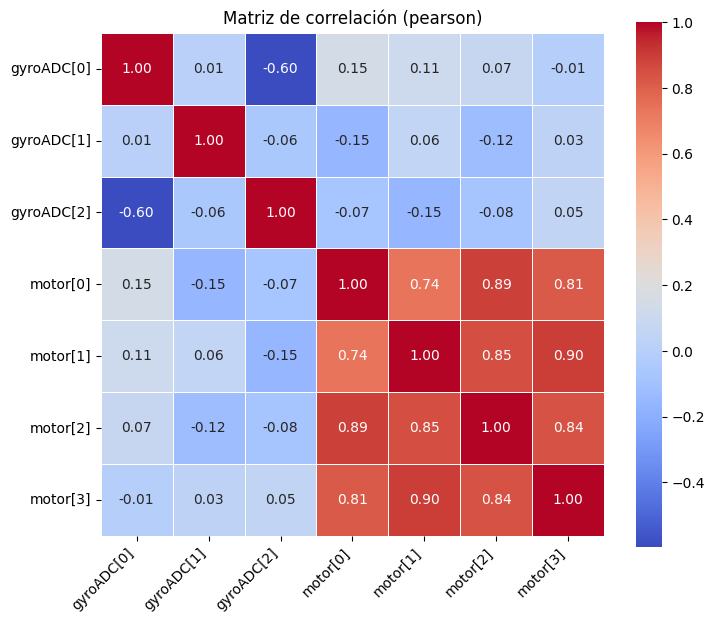

In [9]:
def corr_selected(
    df: pd.DataFrame,
    variables: list,
    method: str = "pearson",
    plot: bool = True,
    cmap: str = "coolwarm",
    save_path: str = None,
) -> pd.DataFrame:
    """
    Calcula la matriz de correlación para las variables seleccionadas y la grafica.
    Opcionalmente guarda el heatmap en formato SVG.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con los datos completos.
    variables : list
        Lista de nombres de columnas a usar para la correlación.
    method : str
        Método de correlación ('pearson', 'spearman', 'kendall').
    plot : bool
        Si True, dibuja un heatmap de la matriz de correlación.
    cmap : str
        Colormap para el heatmap de Seaborn.
    save_path : str, opcional
        Ruta de archivo para guardar el heatmap en formato SVG. Si None, no guarda.

    Retorna:
    --------
    pd.DataFrame
        Matriz de correlación (DataFrame cuadrado) entre las variables seleccionadas.
    """
    # Verificar que las variables existan en el DataFrame
    valid_vars = [col for col in variables if col in df.columns]
    if not valid_vars:
        raise ValueError(
            "Ninguna de las variables seleccionadas existe en el DataFrame."
        )

    # Calcular la matriz de correlación
    corr_df = df[valid_vars].corr(method=method)

    # Graficar si se solicita
    if plot:
        plt.figure(figsize=(len(valid_vars) * 0.5 + 4, len(valid_vars) * 0.5 + 4))
        ax = sns.heatmap(
            corr_df,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            cbar_kws={"shrink": 0.75},
            square=True,
            linewidths=0.5,
        )
        plt.title(f"Matriz de correlación ({method})")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        # Guardar si se indicó ruta
        if save_path:
            plt.savefig(save_path, format="svg")
        plt.show()

    return corr_df


# 2) Matriz de correlación para las variables seleccionadas
corr_df = corr_selected(
    df_limpio,
    variables_seleccionadas,
    method="pearson",
    save_path="Imágenes/Matriz de correlación.svg",
)
# display(corr_df)

#### Matriz de información mutua

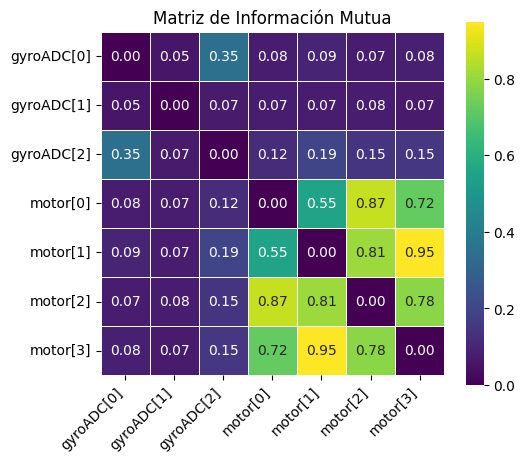

In [10]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression


def mutual_info_matrix_fast(
    df: pd.DataFrame,
    variables: list,
    n_neighbors: int = 3,
    random_state: int = 42,
    max_samples: int = 2000,
) -> pd.DataFrame:
    """
    Calcula la matriz de información mutua entre pares de variables continuas de forma acelerada,
    muestreando un subconjunto de filas.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene las columnas de interés.
    variables : list
        Lista de nombres de columnas para las cuales calcular la información mutua.
    n_neighbors : int
        Número de vecinos para la estimación de MI (3-5 suele funcionar bien).
    random_state : int
        Semilla para reproducibilidad del muestreo y de la estimación.
    max_samples : int
        Número máximo de filas a tomar aleatoriamente para estimar MI.
        Si max_samples=0, se usa todo el DataFrame (más lento).

    Retorna:
    --------
    mi_df : pd.DataFrame
        DataFrame cuadrado con la estimación de la información mutua (simétrica) entre cada par.
    """
    # 1) Filtrar sólo las columnas válidas y eliminar filas con NaN en esas columnas
    valid_vars = [v for v in variables if v in df.columns]
    if not valid_vars:
        raise ValueError(
            "Ninguna de las variables seleccionadas existe en el DataFrame."
        )

    data = df[valid_vars].dropna()
    n_total = len(data)

    # 2) Muestreo de filas (si max_samples > 0)
    if max_samples > 0 and n_total > max_samples:
        # Tomar max_samples filas aleatorias
        data = data.sample(n=max_samples, random_state=random_state)
    elif n_total == 0:
        raise ValueError("No hay filas válidas después de eliminar NaN.")

    # 3) Inicializar la matriz de MI con ceros
    mi_matrix = pd.DataFrame(
        np.zeros((len(valid_vars), len(valid_vars))),
        index=valid_vars,
        columns=valid_vars,
    )

    # 4) Calcular MI para cada par (sólo mitad superior), promediando ambas direcciones
    for i, j in combinations(valid_vars, 2):
        # MI(i->j)
        X_ij = data[[i]].values
        y_j = data[j].values
        mi_ij = mutual_info_regression(
            X_ij, y_j, n_neighbors=n_neighbors, random_state=random_state
        )[0]

        # MI(j->i)
        X_ji = data[[j]].values
        y_i = data[i].values
        mi_ji = mutual_info_regression(
            X_ji, y_i, n_neighbors=n_neighbors, random_state=random_state
        )[0]

        mi = 0.5 * (mi_ij + mi_ji)
        mi_matrix.loc[i, j] = mi
        mi_matrix.loc[j, i] = mi

    # 5) Llenar diagonal con ceros (o con entropía si se quisiera)
    np.fill_diagonal(mi_matrix.values, 0.0)
    return mi_matrix


def plot_mutual_info_heatmap(
    mi_df: pd.DataFrame, cmap: str = "viridis", save_path: str = None
):
    """
    Grafica un heatmap de la matriz de información mutua.

    Parámetros:
    -----------
    mi_df : pd.DataFrame
        DataFrame cuadrado con valores de MI estimada entre pares de variables.
    cmap : str
        Colormap para el heatmap.
    save_path : str, opcional
        Ruta para guardar la figura en formato SVG. Si None, no guarda.
    """
    plt.figure(figsize=(mi_df.shape[0] * 0.5 + 2, mi_df.shape[1] * 0.5 + 2))
    ax = sns.heatmap(
        mi_df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={"shrink": 0.75},
        square=True,
        linewidths=0.5,
    )
    plt.title("Matriz de Información Mutua")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="svg")
    plt.show()


# 1) Información mutua
muinma_df = mutual_info_matrix_fast(
    df_limpio, max_samples=10000, variables=variables_seleccionadas
)
plot_mutual_info_heatmap(
    muinma_df, save_path="Imágenes/Matriz de información mutua.svg"
)

#### Matriz de correlación parcial

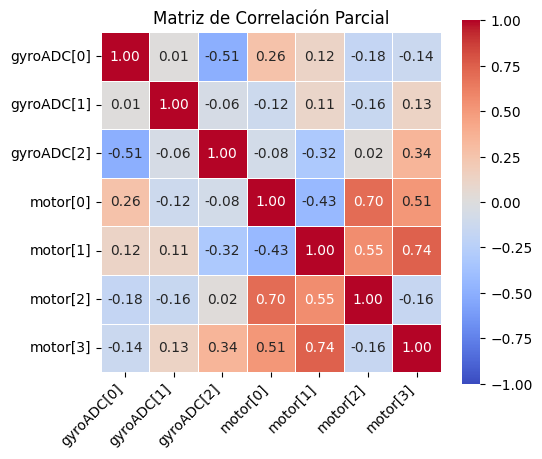

In [11]:
def partial_correlation_matrix(df: pd.DataFrame, variables: list) -> pd.DataFrame:
    """
    Calcula la matriz de correlación parcial entre las variables seleccionadas,
    controlando cada par por todas las demás.

    Basado en la inversa de la matriz de covarianza (método de matriz de precisión).

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene las columnas de interés.
    variables : list
        Lista de nombres de columnas para las cuales calcular correlación parcial.

    Retorna:
    --------
    pcorr_df : pd.DataFrame
        DataFrame con la correlación parcial entre cada par de variables.
    """
    valid_vars = [v for v in variables if v in df.columns]
    data = df[valid_vars].dropna()
    # Matriz de covarianza
    cov = np.cov(data.values, rowvar=False)
    # Matriz de precisión (inversa de cov)
    prec = np.linalg.pinv(cov)
    d = np.sqrt(np.diag(prec))
    denom = np.outer(d, d)
    pcorr = -prec / denom
    np.fill_diagonal(pcorr, 1.0)
    pcorr_df = pd.DataFrame(pcorr, index=valid_vars, columns=valid_vars)
    return pcorr_df


def plot_partial_correlation_heatmap(
    pcorr_df: pd.DataFrame, cmap: str = "coolwarm", save_path: str = None
):
    """
    Grafica un heatmap de la matriz de correlación parcial.

    Parámetros:
    -----------
    pcorr_df : pd.DataFrame
        DataFrame cuadrado con valores de correlación parcial entre pares de variables.
    cmap : str
        Colormap para el heatmap.
    save_path : str
        Ruta para guardar la figura en formato SVG. Si None, no guarda.

    Retorna:
    --------
    None (muestra el heatmap).
    """
    plt.figure(figsize=(pcorr_df.shape[0] * 0.5 + 2, pcorr_df.shape[1] * 0.5 + 2))
    ax = sns.heatmap(
        pcorr_df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={"shrink": 0.75},
        square=True,
        linewidths=0.5,
        vmin=-1,
        vmax=1,
    )
    plt.title("Matriz de Correlación Parcial")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="svg")
    plt.show()


# 2) Correlación parcial
pcorr_df = partial_correlation_matrix(df_limpio, variables_seleccionadas)
plot_partial_correlation_heatmap(
    pcorr_df, save_path="Imágenes/Matriz de correlación parcial.svg"
)

#### Diagrama de dispersión 

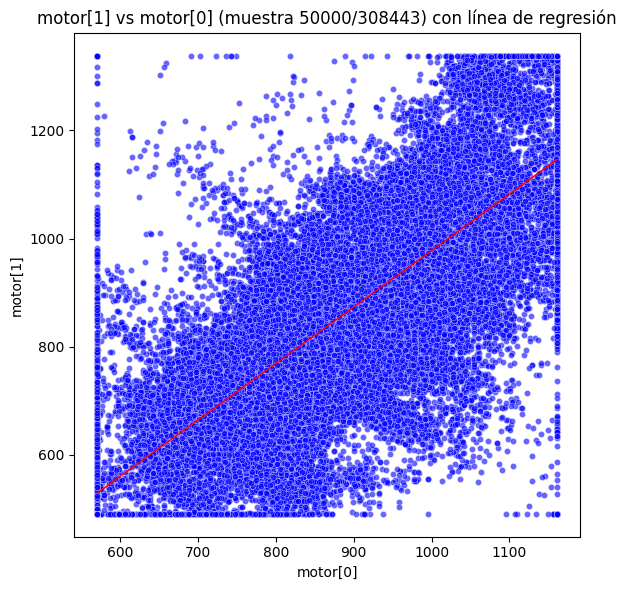

<Axes: title={'center': 'motor[1] vs motor[0] (muestra 50000/308443) con línea de regresión'}, xlabel='motor[0]', ylabel='motor[1]'>

In [12]:
def plot_scatter_with_regression_fast(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str = None,
    sample_n: int = 1000,
    random_state: int = 42,
    save_path: str = None,
):
    """
    Genera un scatterplot acelerado con una línea de regresión lineal ajustada entre dos variables,
    muestreando un subconjunto de puntos para graficar y ajustar la regresión.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene las columnas de interés.
    x : str
        Nombre de la variable en el eje X.
    y : str
        Nombre de la variable en el eje Y.
    hue : str, opcional
        Nombre de la columna categórica para colorear puntos.
    sample_n : int
        Número máximo de filas a muestrear aleatoriamente para el scatter y el ajuste.
        Si sample_n=0, se usa todo el DataFrame (más lento).
    random_state : int
        Semilla para reproducibilidad del muestreo.
    save_path : str, opcional
        Ruta de archivo para guardar el gráfico en formato SVG. Si None, no guarda.

    Retorna:
    --------
    ax : matplotlib.axes.Axes
        Eje donde se dibujó el scatter con regresión.
    """
    # Verificar variables
    if x not in df.columns or y not in df.columns:
        raise ValueError(f"Las variables {x} o {y} no existen en el DataFrame.")

    # Datos sin NaN en x,y,(hue)
    cols = [x, y] + ([hue] if hue and hue in df.columns else [])
    data = df[cols].dropna()
    n_total = len(data)

    # Muestreo
    if sample_n > 0 and n_total > sample_n:
        data_sample = data.sample(n=sample_n, random_state=random_state)
    else:
        data_sample = data.copy()

    plt.figure(figsize=(6, 6))
    # Scatter de puntos muestreados
    if hue and hue in data_sample.columns:
        ax = sns.scatterplot(
            data=data_sample, x=x, y=y, hue=hue, palette="tab10", s=20, alpha=0.6
        )
    else:
        ax = sns.scatterplot(data=data_sample, x=x, y=y, color="blue", s=20, alpha=0.6)

    # Ajuste de línea de regresión usando también solo la muestra
    sns.regplot(
        data=data_sample,
        x=x,
        y=y,
        scatter=False,
        ax=ax,
        color="red",
        line_kws={"linewidth": 1},
    )

    plt.title(
        f"{y} vs {x} (muestra {len(data_sample)}/{n_total}) con línea de regresión"
    )
    plt.tight_layout()

    # Guardar si se indicó ruta
    if save_path:
        plt.savefig(save_path, format="svg")
    plt.show()
    return ax


# 3) Scatter con regresión
plot_scatter_with_regression_fast(
    df_limpio,
    "motor[0]",
    "motor[1]",
    sample_n=50000,
    save_path="Imágenes/Dispersión entre .svg",
)

#### Pairplot 

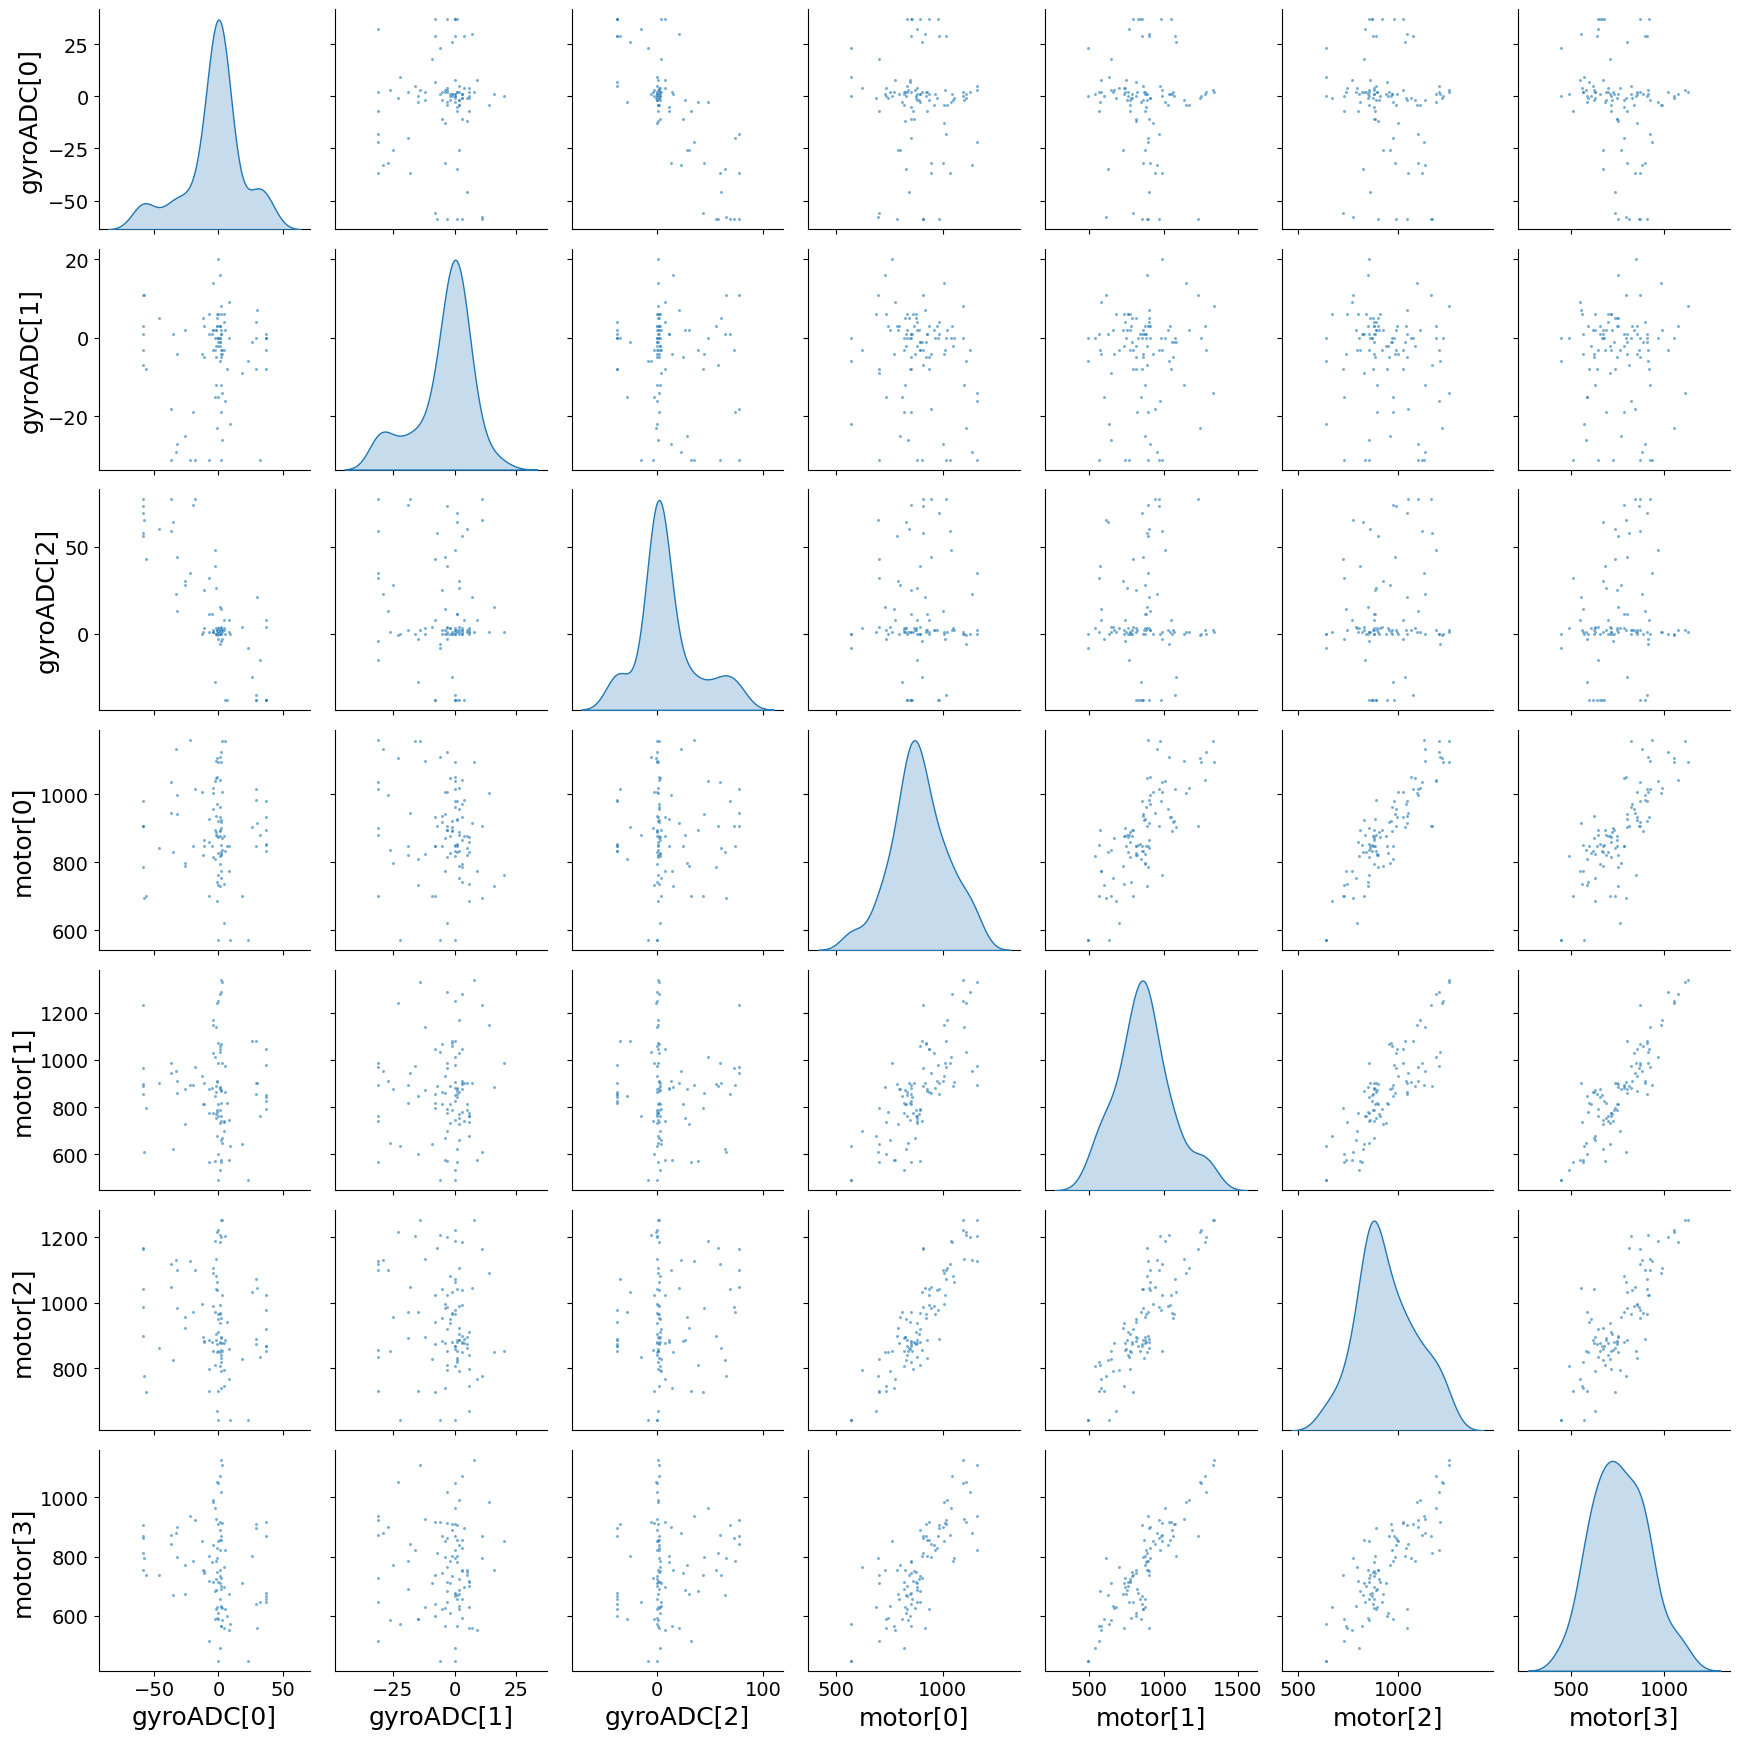

In [13]:
def plot_pairplot(
    df: pd.DataFrame,
    variables: list,
    hue: str = None,
    diag_kind: str = "hist",
    corner: bool = False,
    save_path: str = None,
):
    """
    Genera un pairplot de seaborn para las variables seleccionadas y opcionalmente lo guarda en SVG.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con los datos completos.
    variables : list
        Lista de nombres de columnas a incluir en el pairplot.
    hue : str, opcional
        Nombre de la columna para colorear puntos (categoría). Si None, no se usa.
    diag_kind : str
        Tipo de gráfico en la diagonal ('hist' o 'kde').
    corner : bool
        Si True, muestra solo la mitad inferior del pairplot.
    save_path : str, opcional
        Ruta de archivo para guardar el pairplot en formato SVG. Si None, no guarda.

    Retorna:
    --------
    sns.PairGrid
        Objeto PairGrid generado (se muestra automáticamente).
    """
    # Verificar que las variables existan en el DataFrame
    valid_vars = [col for col in variables if col in df.columns]
    if not valid_vars:
        raise ValueError(
            "Ninguna de las variables seleccionadas existe en el DataFrame."
        )

    plot_vars = valid_vars.copy()
    if hue and hue in df.columns:
        plot_vars.append(hue)

    pairgrid = sns.pairplot(
        df[plot_vars],
        hue=hue if hue in df.columns else None,
        diag_kind=diag_kind,
        corner=corner,
    )
    plt.tight_layout()
    # Guardar si se indicó ruta
    if save_path:
        pairgrid.fig.savefig(save_path, format="svg")
    plt.show()

    return pairgrid


def fast_pairplot(
    df: pd.DataFrame,
    variables: list,
    hue: str = None,
    diag_kind: str = "hist",
    corner: bool = False,
    sample_frac: float = 0.2,
    sample_n: int = 1000,
    random_state: int = 0,
    save_path: str = None,
):
    """
    Genera un pairplot de Seaborn de forma acelerada aplicando muestreo
    y simplificando la cuadrícula de variables.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con los datos completos.
    variables : list
        Lista de columnas a incluir en el pairplot.
    hue : str, opcional
        Nombre de la columna para colorear puntos (p. ej. un modo de vuelo).
        Si None, no se colorea.
    diag_kind : str
        Tipo de gráfico en la diagonal ('hist' o 'kde').
    corner : bool
        Si True, grafica solo la mitad inferior de la matriz (triángulo inferior).
    sample_frac : float
        Fracción del DataFrame que se va a muestrear aleatoriamente para el pairplot.
        Se usa cuando `sample_n` está en 0.
    sample_n : int
        Número máximo de filas a tomar aleatoriamente para el pairplot.
        Si > 0, se ignora `sample_frac` y se toma un muestreo de tamaño `sample_n`.
    random_state : int
        Semilla para reproducibilidad del muestreo.
    save_path : str, opcional
        Ruta de archivo para guardar el pairplot en SVG. Si None, no guarda.

    Retorna:
    --------
    sns.PairGrid
        Objeto PairGrid generado (se muestra y opcionalmente se guarda como SVG).
    """
    # 1) Verificar variables válidas
    valid_vars = [col for col in variables if col in df.columns]
    if not valid_vars:
        raise ValueError(
            "Ninguna de las variables seleccionadas existe en el DataFrame."
        )

    # 2) Tomar muestreo del DataFrame para acelerar graficado
    n_total = len(df)
    if sample_n and sample_n < n_total:
        df_subset = df.sample(n=sample_n, random_state=random_state)[
            valid_vars + ([hue] if hue and hue in df.columns else [])
        ]
    elif 0 < sample_frac < 1.0 and n_total > 1:
        df_subset = df.sample(frac=sample_frac, random_state=random_state)[
            valid_vars + ([hue] if hue and hue in df.columns else [])
        ]
    else:
        # Si no se especifica sample_n ni sample_frac, se usa todo el DataFrame
        df_subset = df[valid_vars + ([hue] if hue and hue in df.columns else [])]

    # 3) Configurar tamaño de figura en función de número de variables
    n_vars = len(valid_vars)
    # Definimos un tamaño base: por cada variable, 0.5 unidad;
    # luego le sumamos un margen. Ajusta si lo ves muy grande/pequeño.
    fig_size = (n_vars * 0.5 + 2, n_vars * 0.5 + 2)

    # 4) Construir el pairplot
    pairgrid = sns.pairplot(
        df_subset,
        vars=valid_vars,
        hue=hue if hue in df_subset.columns else None,
        diag_kind=diag_kind,
        corner=corner,
        plot_kws={
            "s": 5,
            "alpha": 0.6,
        },  # reducir tamaño de marcador y hacerlo parcialmente transparente
        diag_kws={"linewidth": 1},
    )
    # Ajustar tamaño de ticks
    for ax in pairgrid.axes.flatten():
        if ax is not None:
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.xaxis.label.set_size(18)
            ax.yaxis.label.set_size(18)
    
    # Ajustar títulos en la diagonal
    for ax in pairgrid.diag_axes:
        if ax is not None:
            ax.set_title(ax.get_title(), fontsize=15)
    
    plt.tight_layout()

    # 5) Guardar en formato SVG si se indicó ruta
    if save_path:
        pairgrid.fig.savefig(save_path, format="svg")

    plt.show()
    return pairgrid


# 3) Pairplot para las variables seleccionadas (sin hue)
# Supongamos que ya tienes df_clean (el DataFrame post-limpieza) y quieres ver solo
# los ejes del acelerómetro y el giroscopio yaw, sin hue.
plot = fast_pairplot(
    df_limpio,
    variables=variables_seleccionadas,
    hue=None,
    diag_kind="kde",
    corner=False,
    sample_n=100,
    save_path="Imágenes/Pairplot de variables seleccionadas.svg",
)